In [1]:
import torchlm
from torchlm.tools import faceboxesv2
from torchlm.models import pipnet
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

img_path = './align_img/输入网络的图片.jpg'

img_path2 = './align_img/输入网络的图片.jpg'

# # 加载图像
image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # origin image in BGR
print(image.shape)

image2 = cv2.imread(img_path2, cv2.IMREAD_COLOR)  # origin image in BGR
# #
# # # # 将图像转换为 NumPy 数组，并将其转换为 BGR 格式
# # image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
# img = np.float32(image)

# im_height, im_width, _ = img.shape
# scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
# scale = scale.to(device)


# img -= (104, 117, 123) # mean substruction to reduce illumination changes
# img = img.transpose(2, 0, 1)[None, :]

# Batch_size = img.shape[0]

# # # show the origin image
# # plt.imshow(image[:,:,::-1]/255)


(416, 320, 3)


In [3]:
image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # origin image in BGR
image_tensor = torch.from_numpy(image[:,:,::-1]/255).permute(2,0,1).unsqueeze(0).float()

image2 = cv2.imread(img_path2, cv2.IMREAD_COLOR)  # origin image in BGR
torchlm.runtime.bind(faceboxesv2(device="cpu"))  # set device="cuda" if you want to run with CUDA
# set map_location="cuda" if you want to run with CUDA
torchlm.runtime.bind(
  pipnet(backbone="resnet101", weights =True,  
         num_nb=10, num_lms=68, net_stride=32, input_size=256,
         meanface_type="300w", map_location="cpu", checkpoint=None) 
) # will auto download pretrained weights from latest release if pretrained=True
landmarks, bboxes = torchlm.runtime.forward(image)
# print(landmarks[0])
image = torchlm.utils.draw_bboxes(image, bboxes=bboxes)
#
image = torchlm.utils.draw_landmarks(image, landmarks=landmarks[0])

landmarks2, bboxes2 = torchlm.runtime.forward(image2)
image2 = torchlm.utils.draw_bboxes(image2, bboxes=bboxes2)
image2 = torchlm.utils.draw_landmarks(image2, landmarks=landmarks2)



/root/miniconda3/envs/DJL_codeformer/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
landmark1_tensor = torch.from_numpy(landmarks/image.shape[:2])
landmark2_tensor = torch.from_numpy(landmarks2/image2.shape[:2])




In [5]:
# plt.imshow(image[:,:,::-1]/255)

In [6]:
class AffineEstimator(nn.Module):
  def __init__(self, dim=2 ,mode='affine'):
    super(AffineEstimator, self).__init__()
    self.dim = dim

  def forward_iterative(self, X: torch.Tensor, Y: torch.Tensor, t=10, return_loss=False):
    Xt = X
    Yt = Y
    for i in range(t):
      affine_matrix, score, Xt, _ = self.forward(Xt, Yt, return_loss=return_loss)
      affine_matrix, score, Yt, _ = self.forward(Yt, Xt, return_loss=return_loss)

    #affine_matrix, score, Xt, Yt =  self.forward(Xt, Yt, return_loss=return_loss)
    return affine_matrix, score, Xt, Yt


 
  def forward(self, X: torch.Tensor, Y: torch.Tensor, return_loss=False):
    """
    X: (batch, num_points, dim)
    Y: (batch, num_points, dim)
    """

    assert X.shape == Y.shape  
    assert X.shape[2] == self.dim

    X_mean = torch.mean(X, dim=-2, keepdim=True)
    Y_mean = torch.mean(Y, dim=-2, keepdim=True)
    X_std = torch.std(X, dim=-2, keepdim=True)
    Y_std = torch.std(Y, dim=-2, keepdim=True)

    x = (X - X_mean) / X_std 
    y = (Y - Y_mean) / Y_std

    x = torch.cat([x, torch.ones_like(x[:, :, :1])], dim=-1)
    
    # Solve the least square problem
    xTx = torch.matmul( x.transpose(-1, -2),x)
    xTy = torch.matmul( x.transpose(-1, -2),y)
    xTx_inv = torch.inverse(xTx+1e-6*torch.eye(xTx.shape[-1], device=xTx.device))
    affine0 = torch.matmul(xTx_inv, xTy)

    A0 = affine0[:, :2, :2]
    T0 = affine0[:, 2:, :2]
    A = A0*Y_std/X_std
    T = Y_mean - torch.matmul(X_mean, A)*Y_std/X_std + T0*Y_std

    # print(A.shape, T.shape)
    affine = torch.cat([A, T], dim=-2)
    # print(affine.shape)

    if return_loss:
        X1 = torch.matmul(torch.cat([X, torch.ones_like(X[:, :, :1])], dim=-1), affine)
        loss = torch.mean(torch.norm(torch.matmul(torch.cat([X, torch.ones_like(X[:, :, :1])], dim=-1), affine) - Y, dim=1))
        return affine.transpose(-1, -2), loss, X1, Y

    return affine.transpose(-1, -2)

In [7]:
affineEstimator = AffineEstimator(dim=2, mode='affine').to(device)
# affine_matrix, score = affineEstimator(landmark2_tensor[:,48:,:], landmark1_tensor[:,48:,:], return_loss=True)

affine_matrix, score, Y1, X = affineEstimator.forward_iterative(landmark1_tensor[:,48:,:], landmark1_tensor[:,48:,:]+0.001*torch.randn_like(landmark1_tensor[:,48:,:]), t=10, return_loss=True)
                                                                ## )  #  t= 10, return_loss=True

score

tensor(0.0050, dtype=torch.float64)

tensor([[[ 9.9986e-01, -3.0778e-06,  1.1528e-04],
         [-1.5518e-05,  9.9961e-01,  6.3662e-04]]], dtype=torch.float64)
affineloss: tensor(0.0050, dtype=torch.float64)
torch.Size([1, 68, 2])


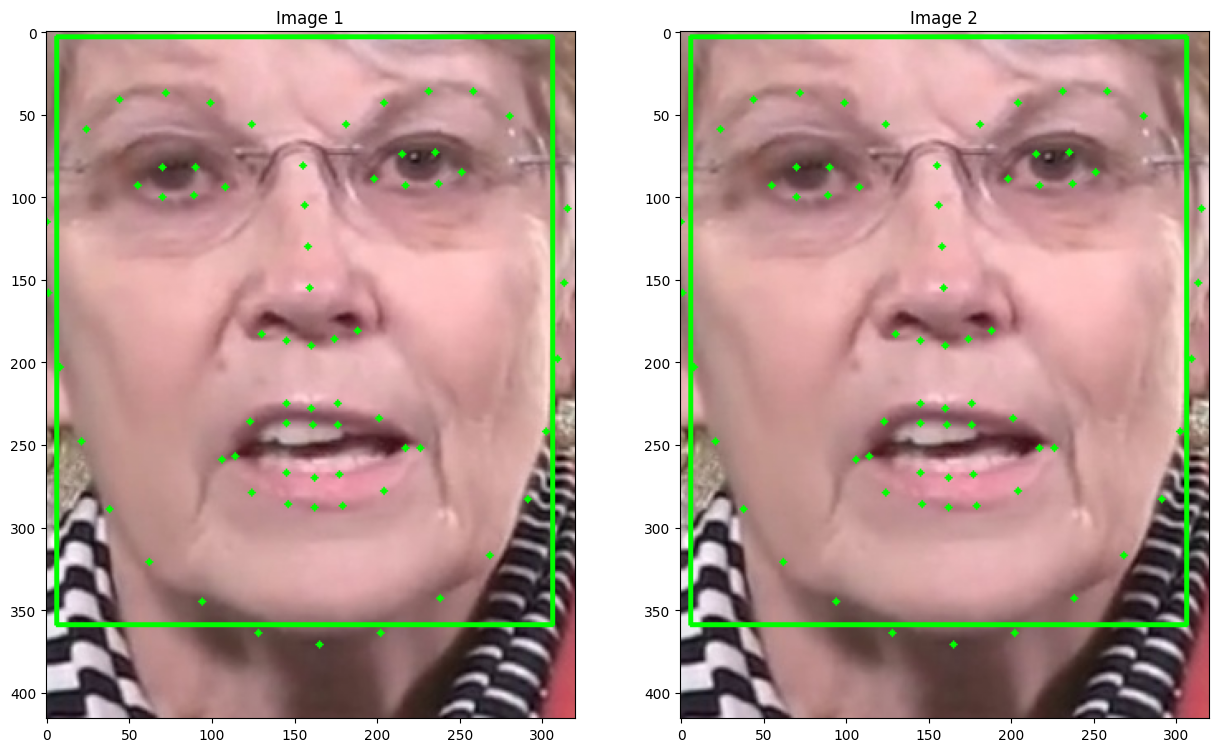

In [8]:
print(affine_matrix)
print("affineloss:",score)

print(landmark1_tensor.shape)

# 创建画布和子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# 在子图1上绘制第一幅图像
ax1.imshow(image[:,:,::-1]/255)
ax1.set_title('Image 1')

# 在子图2上绘制第二幅图像
ax2.imshow(image2[:,:,::-1]/255)
ax2.set_title('Image 2')

# 显示画布
plt.show()

## 从此处开始是dataloader的数据预处理部分


In [9]:
class Sobel_Edge_Detection(nn.Module):
    '''
    Sobel算子检测边缘
    '''
    def __init__(self,dilation=1,padding=0):
        super(Sobel_Edge_Detection, self).__init__()
        self.dilation = dilation
        self.padding = padding
        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        kernel = torch.cat([sobel_x, sobel_y], dim=0)
        self.weight = nn.Parameter(data=kernel, requires_grad=False)
        
    def sobel_to_Gray(self, x):
        
        '''
        x: 3 channel image
        return: 1 channel gray image
        '''
        three_channel_sobel = self.forward(x)
        
        a1 = 0.299
        a2 = 0.587
        a3 = 0.114
        
        x = a1 * three_channel_sobel[:,0,:,:] + a2 * three_channel_sobel[:,1,:,:] + a3 * three_channel_sobel[:,2,:,:]

        print(x.shape)
        
        x = torch.norm(x, dim=-3, keepdim=True) # b*3 1 h
        

        x = torch.where(x>2,2,x)/2
        

        return x
    
    def forward(self, x):   ## 要让这些参数不更新，就要加上requires_grad=False
        '''
        input: 3 channel image
        output: 3 channel edge image
        '''
        with_batch = True if len(x.shape) == 4 else False
        channel_num = x.shape[-3]
        x = x.view((-1,1,)+x.shape[-2:]) # b*3 1 h w
        
        x_reshape = F.conv2d(x, self.weight, padding=self.padding,dilation=self.dilation) # b*3 2 h w (padding)
        #x_reshape = torch.norm(x_reshape, dim=-3, keepdim=True) # b*3 1 h w
        
        # print("x_reshape.max:",torch.max(x_reshape))
        # print("x_reshape.min:",torch.min(x_reshape)) 
        
        # 要加sigmoid 防止梯度爆炸 或者归一化
        
        if with_batch:
            x_reshape = x_reshape.view((-1,channel_num,)+x_reshape.shape[-2:])
        return x_reshape

In [10]:
class Gaussian_bluring(nn.Module):
  def __init__(self, radius=1,sigma=1,padding=0):
    super(Gaussian_bluring, self).__init__()

    self.sigma = sigma
    self.padding = padding
    self.radius = radius
    self.size = self.radius*2+1

    self.kernel = self.get_gaussian_kernel()

    self.weight = nn.Parameter(data=self.kernel.unsqueeze(0).unsqueeze(0), requires_grad=False)
 
  def forward(self, x):
    with_batch = True if len(x.shape) == 4 else False
    channel_num = x.shape[-3]
    x = x.view((-1,1,)+x.shape[-2:])  ## batch * channel * 1 
    x_reshape = F.conv2d(x,self.weight, padding=self.padding)
    if with_batch:
      x_reshape = x_reshape.view((-1,channel_num,)+x_reshape.shape[-2:])  ## 拆回去
    return x_reshape
  
  def get_gaussian_kernel(self):
    constant = 1/(2 * torch.pi * self.sigma**2)
    gaussian_kernel = torch.zeros((self.size, self.size))
    for i in range(0, self.size, 1):
        for j in range(0, self.size, 1):
            x = i-self.radius
            y = j-self.radius
            gaussian_kernel[i, j] = np.exp(-0.5/(self.sigma**2)*(x**2+y**2))

    gaussian_kernel = gaussian_kernel/gaussian_kernel.sum() 
    return gaussian_kernel

# 获取数据预处理之后的图片

In [11]:
Gaussian_bluring_layer = Gaussian_bluring(radius=20,sigma=50,padding='same')

gaussian_blurred_image = Gaussian_bluring_layer(image_tensor)

In [12]:
edge_detected = Sobel_Edge_Detection(dilation=1,padding='same')

edge_detected_image = edge_detected.sobel_to_Gray(image_tensor)

torch.Size([2, 416, 320])


(1, 31, 2)
(1, 31, 2)
heatmap.shape torch.Size([1, 3, 416, 320])
torch.Size([1, 3, 31])
torch.Size([31])
heatmap[:,:,landmarks_index_Y,landmarks_index_X].shape torch.Size([1, 3, 31])
heatmap.shape torch.Size([1, 3, 416, 320])
torch.min(heatmap) tensor(0.)
统计张量中0的数量和比例: tensor(0.9886)
tensor([ 63,  75,  92, 114, 138, 164, 190, 215, 236, 252, 260,  96, 117, 143,
        161, 180, 210, 240, 213, 184, 163, 143, 118, 106, 143, 161, 180, 228,
        182, 163, 143,  35,  51,  72, 101, 132, 165, 198, 230, 258, 278, 288,
        106, 124, 146, 161, 176, 202, 226, 204, 180, 163, 146, 125, 115, 146,
        161, 177, 217, 178, 162, 146,  95, 129, 166, 202, 238])
heatmap_mask[:,:,landmarks_index_Y,landmarks_index_X].shape torch.Size([1, 3, 67])


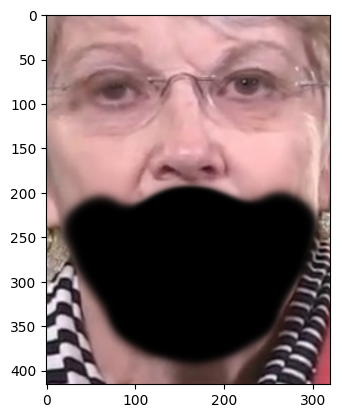

In [41]:
landmarks_keys = landmarks[:,17:48,:]
print(landmarks_keys.shape)
if landmarks_keys.shape[0] != 1:
    landmarks_keys = landmarks_keys[:1]
    
print(landmarks_keys.shape)

landmarks_index_X = torch.from_numpy(landmarks_keys)[:,:,0].round().type(torch.LongTensor).squeeze()

landmarks_index_Y = torch.from_numpy(landmarks_keys)[:,:,1].round().type(torch.LongTensor).squeeze()

heatmap = torch.zeros_like(image_tensor)
print("heatmap.shape",heatmap.shape)

print(heatmap[:,:,landmarks_index_Y,landmarks_index_X].shape)
print(landmarks_index_X.shape)

heatmap[:,:,landmarks_index_Y,landmarks_index_X] = torch.tensor([[1.,1.,1.]]).view(-1,3,1)
print("heatmap[:,:,landmarks_index_Y,landmarks_index_X].shape",heatmap[:,:,landmarks_index_Y,landmarks_index_X].shape)

heatmap_layer = Gaussian_bluring(radius=3,sigma=2,padding='same')

heatmap = heatmap_layer(heatmap)

heatmap = torch.where(heatmap>0,1,heatmap)

print("heatmap.shape",heatmap.shape)
print("torch.min(heatmap)",torch.min(heatmap))

# 统计张量中0的数量和比例
num_zeros = torch.count_nonzero(heatmap == torch.tensor(0.))
total_elements = heatmap.numel()
zero_ratio = num_zeros / total_elements
print("统计张量中0的数量和比例:",zero_ratio)

########### dengjunli ##############################################################

landmarks_keys_test1 = landmarks[:,3:14,:] #


landmarks_keys_test2 = landmarks[:,48:,:] # 

landmarks_keys_test10 = landmarks[:,6:11,:] #

landmarks_keys_test11 = (landmarks_keys_test1 - landmarks[:,30:31,:])*0.7 + landmarks[:,30:31,:]
landmarks_keys_test12 = (landmarks_keys_test1 - landmarks[:,30:31,:])*0.9 + landmarks[:,30:31,:]
landmarks_keys_test21 = (landmarks_keys_test2 - landmarks[:,30:31,:])*1.2 + landmarks[:,30:31,:]



landmarks_keys_test = np.concatenate((landmarks_keys_test11,landmarks_keys_test21,landmarks_keys_test12,landmarks_keys_test2,landmarks_keys_test10),axis=1)



landmarks_index_X_test = torch.from_numpy(landmarks_keys_test)[:,:,0].round().type(torch.LongTensor).squeeze()
print(landmarks_index_X_test)

landmarks_index_Y_test = torch.from_numpy(landmarks_keys_test)[:,:,1].round().type(torch.LongTensor).squeeze()

heatmap_mask = torch.zeros_like(image_tensor)

heatmap_mask[:,:,landmarks_index_Y_test,landmarks_index_X_test] = torch.tensor([[1.,1.,1.]]).view(-1,3,1)
print("heatmap_mask[:,:,landmarks_index_Y,landmarks_index_X].shape",heatmap_mask[:,:,landmarks_index_Y_test,landmarks_index_X_test].shape)

heatmap_layer = Gaussian_bluring(radius=60,sigma=20,padding='same')########

heatmap_mask = heatmap_layer(heatmap_mask)

heatmap_mask = heatmap_mask/heatmap_mask.max()


#heatmap_mask = torch.where(heatmap_mask>0,1,heatmap_mask)

w = torch.sigmoid((heatmap_mask-0.08)*80)  ###########

image_tensor_mix = image_tensor*(1-w)


plt.imshow(image_tensor_mix.squeeze().permute(1,2,0).numpy())


#plt.imshow(heatmap_mask.squeeze().permute(1,2,0).numpy())
########### dengjunli #####################################3

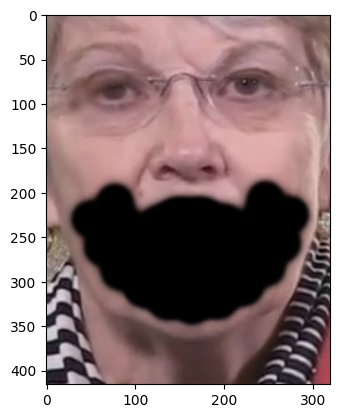

In [14]:

image_tensor_mix = image_tensor*(1-torch.sigmoid((heatmap_mask-0.02)*100))


plt.imshow(image_tensor_mix.squeeze().permute(1,2,0).numpy())



plt.imshow(image_tensor_mix.squeeze().permute(1,2,0).numpy())


x.shape: torch.Size([3])
grid_x.shape: torch.Size([3, 500, 500])
grid_y.shape: torch.Size([3, 500, 500])
heatmap.shape: torch.Size([3, 500, 500])
torch.max(heatmap): tensor(1.)
torch.max(heatmap): tensor(0.0005)
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
he

/root/miniconda3/envs/DJL_codeformer/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343998658/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


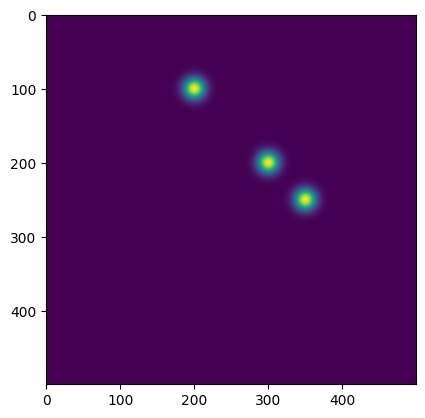

In [15]:
import torch
import torch.nn.functional as F

def generate_heatmap(x, y, H, W, sigma=1.0):
    """
    生成关键点热图
    :param x: 关键点的 x 坐标，形状为 (N,)
    :param y: 关键点的 y 坐标，形状为 (N,)
    :param H: 热图的高度
    :param W: 热图的宽度
    :param sigma: 高斯分布的标准差
    :return: 关键点热图，形状为 (N, H, W)
    """
    N = x.shape[0]  # 关键点数量

    print("x.shape:", x.shape)

    # 创建网格坐标张量
    grid_x, grid_y = torch.meshgrid(torch.arange(W), torch.arange(H))



    grid_x = grid_x.float().to(x.device)
    grid_y = grid_y.float().to(y.device)

    # 将网格坐标张量扩展为形状为 (1, H, W) 的张量
    grid_x = grid_x.unsqueeze(0).repeat(N, 1, 1)
    grid_y = grid_y.unsqueeze(0).repeat(N, 1, 1)

    print("grid_x.shape:", grid_x.shape)
    print("grid_y.shape:", grid_y.shape)

    # 创建坐标张量
    x = x.unsqueeze(-1).unsqueeze(-1).repeat(1, H, W)
    y = y.unsqueeze(-1).unsqueeze(-1).repeat(1, H, W)

    # 计算高斯分布函数
    heatmap = torch.zeros(H, W)
    for i in range(x.shape[0]):
        dist = (grid_x - x[i])**2 + (grid_y - y[i])**2
        heatmap_tmp = torch.exp(-dist / (2 * sigma**2))
        heatmap = heatmap + heatmap_tmp

    print("heatmap.shape:", heatmap.shape)

    print("torch.max(heatmap):", torch.max(heatmap))

    # 对热图进行归一化
    heatmap = heatmap / heatmap.sum(dim=(1, 2), keepdim=True)

    print("torch.max(heatmap):", torch.max(heatmap))

    print(heatmap)


    return heatmap


# 创建关键点坐标张量
x = torch.tensor([100, 200, 250 ], dtype=torch.float32)
y = torch.tensor([200, 300, 350 ], dtype=torch.float32)

# 生成关键点热图
heatmap = generate_heatmap(x, y, H=500, W=500, sigma=10.0)

# 可视化热图
import matplotlib.pyplot as plt
plt.imshow(heatmap[0], cmap='viridis')
print("heatmap[0].shape:", heatmap[0].shape)
plt.show()


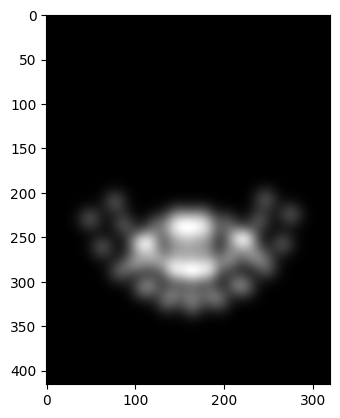

In [16]:
plt.imshow(heatmap_mask.squeeze().permute(1,2,0).numpy())

In [17]:
new_img = gaussian_blurred_image + 1*edge_detected_image.repeat(1,3,1,1) + 0.5*heatmap

print("new_img.shape",new_img.shape)

print(torch.max(gaussian_blurred_image))
print(torch.max(edge_detected_image))
print(torch.max(heatmap))
print(torch.max(new_img))

#new_img = new_img/new_img.max()




RuntimeError: The size of tensor a (320) must match the size of tensor b (500) at non-singleton dimension 3

0.993186

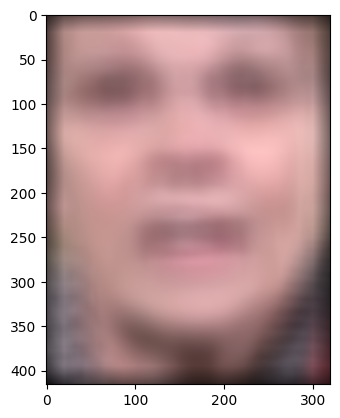

In [ ]:
plt.imshow(gaussian_blurred_image.squeeze().permute(1,2,0).numpy())

np.max(gaussian_blurred_image.squeeze().permute(1,2,0).numpy())

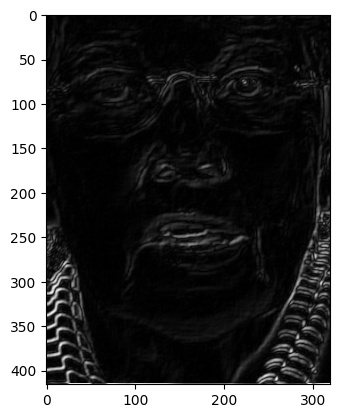

In [ ]:
plt.imshow(edge_detected_image.repeat(1,3,1,1).squeeze().permute(1,2,0).numpy())

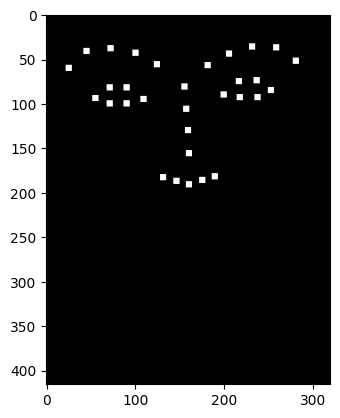

In [ ]:
plt.imshow(heatmap.squeeze().permute(1,2,0).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


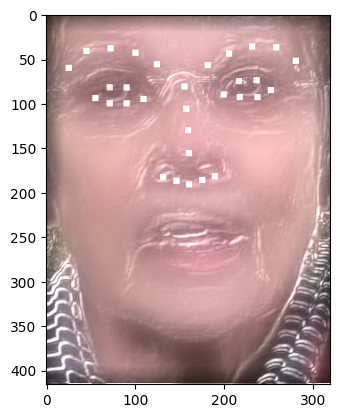

In [ ]:
plt.imshow(new_img.squeeze().permute(1,2,0).numpy())

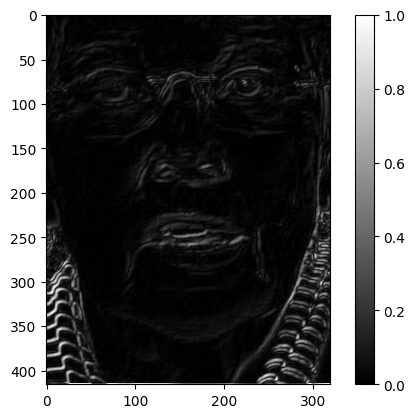

In [ ]:
plt.imshow(edge_detected_image.permute(1,2,0).numpy(),cmap='gray')

# print(edge_detected_image.shape)

# # img = edge_detected_image.detach().cpu().numpy()

# # # 将张量的值的范围从 [0, 1] 转换为 [0, 255]
# # img = (img * 255).round().astype(np.uint8)


plt.colorbar()

# 最后还差一个crop